# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [219]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
from collections import defaultdict
import math


In [220]:
df = pd.read_csv("amazon_reviews.csv")

df.head()

,Title,Content,Star
0,Didn't work,No change in nails at all.,1.0
1,Worst nail product I have ever used.,Garbage! Do not waste your $$$. My nails were ...,1.0
2,Just didn't work,Nails are still brittle,1.0
3,Scum,Didn’t do any improvement at all.,1.0
4,Okay for cuticles,"Helped cuticles, didn't do much for my nails. ...",1.0


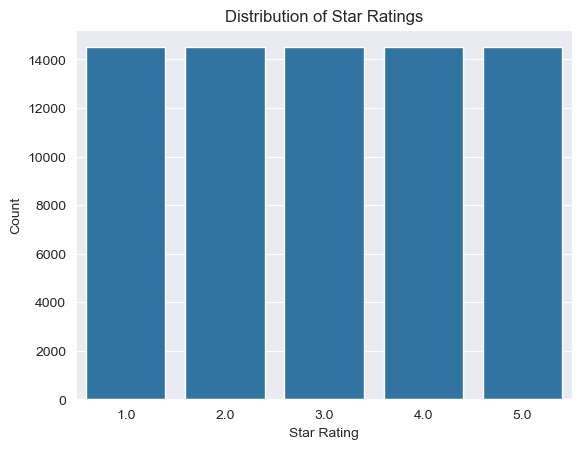

In [221]:
sns.countplot(x='Star', data=df)
plt.title("Distribution of Star Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.show()


In [222]:
df['title_length'] = df['Title'].astype(str).apply(lambda x: len(x.split()))
df['content_length'] = df['Content'].astype(str).apply(lambda x: len(x.split()))


In [223]:
print("Average Title Length:", df['title_length'].mean())
print("Average Content Length:", df['content_length'].mean())


Average Title Length: 4.170965517241379
Average Content Length: 36.46804137931034


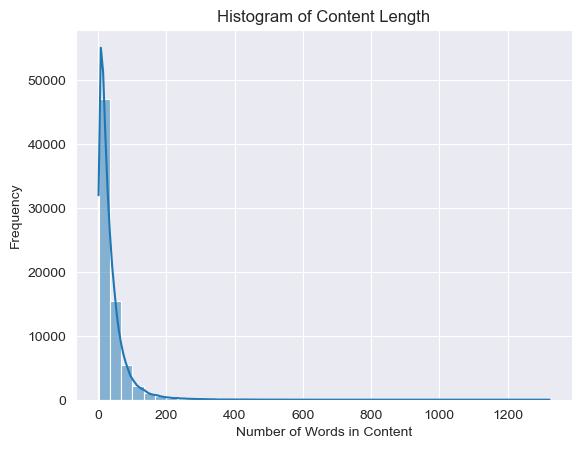

In [224]:
sns.histplot(df['content_length'], bins=40, kde=True)
plt.title("Histogram of Content Length")
plt.xlabel("Number of Words in Content")
plt.ylabel("Frequency")
plt.show()


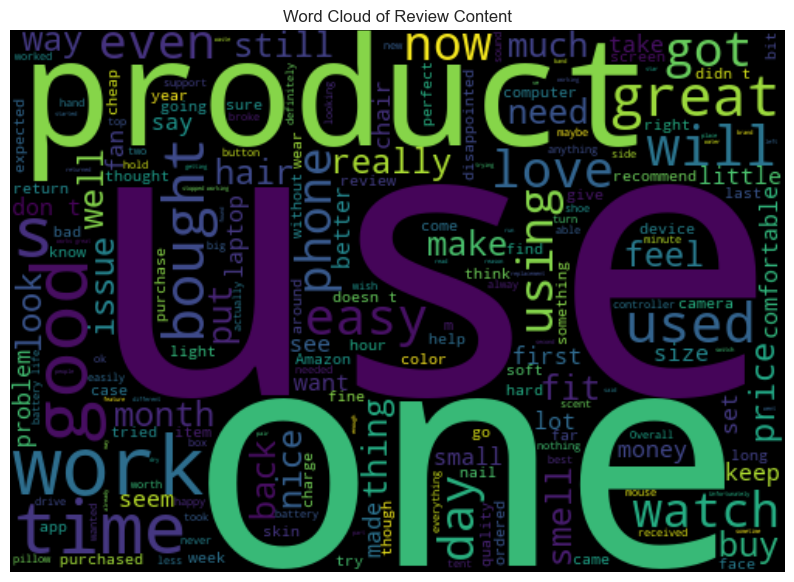

In [225]:
text = " ".join(review for review in df['Content'].astype(str))
wordcloud = WordCloud(width=500, height=350).generate(text)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Review Content")
plt.show()


In [226]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s.,!?]', '', text)  # keep . , ! ? for n-gram purposes
    return text

df['Title'] = df['Title'].astype(str).apply(clean_text)
df['Content'] = df['Content'].astype(str).apply(clean_text)
df['Combined'] = df['Title'] + " " + df['Content']


In [227]:
def tokenize(text, n=1):
    words = text.split()
    if n == 1:
        return words
    elif n == 2:
        return [f"{words[i]} {words[i+1]}" for i in range(len(words)-1)]
    elif n == 3:
        return [f"{words[i]} {words[i+1]} {words[i+2]}" for i in range(len(words)-2)]


In [228]:
sample = df['Combined'].iloc[0]
print("Unigrams:", tokenize(sample, 1))
print("Bigrams:", tokenize(sample, 2))


Unigrams: ['didnt', 'work', 'no', 'change', 'in', 'nails', 'at', 'all.']
Bigrams: ['didnt work', 'work no', 'no change', 'change in', 'in nails', 'nails at', 'at all.']


In [229]:
def get_token_frequencies(texts, n_gram):
    freq = defaultdict(int)

    for text in texts:
        if n_gram == 1:
            tokens = remove_stopwords(tokenize(text, 1))
        elif n_gram == 2:
            tokens = remove_stopwords_from_bigrams(tokenize(text, 2))
        elif n_gram == "combined":
            tokens = remove_stopwords(tokenize(text, 1)) + remove_stopwords_from_bigrams(tokenize(text, 2))
        else:
            tokens = tokenize(text, n_gram)

        for token in tokens:
            freq[token] += 1

    return freq


In [230]:
stopwords = {"i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"}


def remove_stopwords(tokens):
    return [token for token in tokens if token not in stopwords]


df['clean_tokens'] = df['Combined'].apply(lambda x: remove_stopwords(tokenize(x, 1)))


def remove_stopwords_from_bigrams(bigrams):
    return [bigram for bigram in bigrams
            if all(word not in stopwords for word in bigram.split())]

df['clean_bigrams'] = df['Combined'].apply(lambda x: remove_stopwords_from_bigrams(tokenize(x, 2)))

print("Before:", tokenize(df['Combined'].iloc[0], 1))
print("After :", remove_stopwords(tokenize(df['Combined'].iloc[0], 1)))

Before: ['didnt', 'work', 'no', 'change', 'in', 'nails', 'at', 'all.']
After : ['didnt', 'work', 'change', 'nails', 'all.']


In [231]:
def label_sentiment(star):
    if star in [1, 2]:
        return 0  # Negative
    elif star in [4, 5]:
        return 1  # Positive
    else:
        return None  # Neutral or ignored

df['Label'] = df['Star'].apply(label_sentiment)
df = df.dropna(subset=['Label'])  # Drop rows with 3-star or missing labels


In [232]:
df.loc[:, 'Combined'] = df['Title'].astype(str) + " " + df['Content'].astype(str)

In [233]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['Label']
)


In [234]:
# Count token frequencies on training data
min_freq = 2  # You can adjust if needed
token_freq = get_token_frequencies(train_df['Combined'], n_gram="combined")

# Build set of known tokens
known_tokens = set(token for token, count in token_freq.items() if count >= min_freq)


In [235]:
def build_unigram_dict(texts):
    unigram_freq = defaultdict(int)
    for text in texts:
        tokens = remove_stopwords(tokenize(text, 1))  # tokenized + cleaned
        for token in tokens:
            unigram_freq[token] += 1
    return dict(unigram_freq)

unigram_dict = build_unigram_dict(train_df['Combined'])


def build_bigram_dict(texts):
    bigram_freq = defaultdict(int)
    for text in texts:
        bigrams = remove_stopwords_from_bigrams(tokenize(text, 2))
        for bigram in bigrams:
            bigram_freq[bigram] += 1
    return dict(bigram_freq)

bigram_dict = build_bigram_dict(train_df['Combined'])



def build_trigram_dict(texts):
    trigram_freq = defaultdict(int)
    for text in texts:
        trigrams = tokenize(text, 3)  # no stopword removal for now (optional)
        for trigram in trigrams:
            trigram_freq[trigram] += 1
    return dict(trigram_freq)

trigram_dict = build_trigram_dict(train_df['Combined'])



print("Top 10 Unigrams:")
print(Counter(unigram_dict).most_common(10))

print("\nTop 10 Bigrams:")
print(Counter(bigram_dict).most_common(10))

Top 10 Unigrams:
[('great', 9826), ('good', 9592), ('like', 7911), ('one', 6758), ('use', 6000), ('would', 5955), ('product', 5754), ('dont', 5474), ('get', 5227), ('work', 4321)]

Top 10 Bigrams:
[('stopped working', 768), ('battery life', 686), ('works great', 587), ('doesnt work', 577), ('great product', 574), ('dont buy', 547), ('good quality', 493), ('works well', 447), ('good product', 439), ('didnt work', 425)]


In [236]:
class NaiveBayesClassifier:
    def __init__(self, n_gram=1):
        self.n_gram = n_gram
        self.class_token_counts = defaultdict(lambda: defaultdict(int))
        self.class_total_tokens = defaultdict(int)
        self.class_doc_counts = defaultdict(int)
        self.vocabulary = set()
        self.num_docs = 0
        self.known_tokens = None  # Will set it externally before training



    def train(self, texts, labels, stars):
        for text, label, star in zip(texts, labels, stars):
            self.class_doc_counts[label] += 1
            self.num_docs += 1

            # Determine weighting factor
            weight = 1.0
            if label == 0:  # Negative
                weight = 1.0 if star == 1 else 0.5
            elif label == 1:  # Positive
                weight = 1.0 if star == 5 else 0.5

            # Tokenization
            if self.n_gram == 1:
                tokens = remove_stopwords(tokenize(text, 1))
            elif self.n_gram == 2:
                tokens = remove_stopwords_from_bigrams(tokenize(text, 2))
            elif self.n_gram == "combined":
                uni = remove_stopwords(tokenize(text, 1))
                bi = remove_stopwords_from_bigrams(tokenize(text, 2))
                tokens = uni + bi
            else:
                tokens = tokenize(text, self.n_gram)

            for token in tokens:
                 if self.known_tokens is not None:
                        token = token if token in self.known_tokens else "<UNK>"
                 self.vocabulary.add(token)
                 self.class_token_counts[label][token] += weight
                 self.class_total_tokens[label] += weight

    def predict_with_weights(self, title, content, title_weight=0.3, content_weight=0.7):
        if self.n_gram == 1:
            title_tokens = remove_stopwords(tokenize(title, 1))
            content_tokens = remove_stopwords(tokenize(content, 1))
        elif self.n_gram == 2:
            title_tokens = remove_stopwords_from_bigrams(tokenize(title, 2))
            content_tokens = remove_stopwords_from_bigrams(tokenize(content, 2))
        elif self.n_gram == "combined":
            title_tokens = (
                remove_stopwords(tokenize(title, 1)) +
                remove_stopwords_from_bigrams(tokenize(title, 2))
            )
            content_tokens = (
            remove_stopwords(tokenize(content, 1)) +
            remove_stopwords_from_bigrams(tokenize(content, 2))
            )
        else:
            title_tokens = tokenize(title, self.n_gram)
            content_tokens = tokenize(content, self.n_gram)

        class_scores = {}

        for c in self.class_doc_counts:
            # Prior: log P(C)
            log_prob = math.log(self.class_doc_counts[c] / self.num_docs)
            total_tokens = self.class_total_tokens[c]
            vocab_size = len(self.vocabulary)

            # Weighted title contribution
            for token in title_tokens:
                token = token if token in self.vocabulary else "<UNK>"
                token_count = self.class_token_counts[c].get(token, 0)
                prob = (token_count + 1) / (total_tokens + vocab_size)
                log_prob += title_weight * math.log(prob)

            # Weighted content contribution
            for token in content_tokens:
                token = token if token in self.vocabulary else "<UNK>"
                token_count = self.class_token_counts[c].get(token, 0)
                prob = (token_count + 1) / (total_tokens + vocab_size)
                log_prob += content_weight * math.log(prob)

            class_scores[c] = log_prob

        return max(class_scores, key=class_scores.get)


# Pass known_tokens
nb_comb = NaiveBayesClassifier(n_gram="combined")
nb_comb.known_tokens = known_tokens
nb_comb.train(train_df['Combined'], train_df['Label'], train_df['Star'])



#Training
nb_unigram = NaiveBayesClassifier(n_gram=1)
nb_bigram = NaiveBayesClassifier(n_gram=2)

nb_unigram.train(train_df['Combined'], train_df['Label'], train_df['Star'])
nb_bigram.train(train_df['Combined'], train_df['Label'], train_df['Star'])


# UNIGRAM predictions
test_df['pred_uni'] = test_df.apply(
    lambda row: nb_unigram.predict_with_weights(row['Title'], row['Content'], 0.6, 0.4),
    axis=1
)

# BIGRAM predictions
test_df['pred_bi'] = test_df.apply(
    lambda row: nb_bigram.predict_with_weights(row['Title'], row['Content'], 0.6, 0.4),
    axis=1
)

# COMBINED (unigram + bigram) predictions
nb_comb = NaiveBayesClassifier(n_gram="combined")
nb_comb.train(train_df['Combined'], train_df['Label'], train_df['Star'])

test_df['pred_comb'] = test_df.apply(
    lambda row: nb_comb.predict_with_weights(row['Title'], row['Content'], 0.6, 0.4),
    axis=1
)


In [237]:
def compute_metrics(y_true, y_pred):
    TP = FP = TN = FN = 0

    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            TP += 1
        elif true == 0 and pred == 1:
            FP += 1
        elif true == 0 and pred == 0:
            TN += 1
        elif true == 1 and pred == 0:
            FN += 1

    accuracy = (TP + TN) / (TP + TN + FP + FN) if TP + TN + FP + FN > 0 else 0
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 / (1/precision + 1/recall) if precision + recall > 0 else 0

    return {
        "TP": TP, "TN": TN, "FP": FP, "FN": FN,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }



# Compute metrics separately for each model
metrics_uni = compute_metrics(test_df['Label'].tolist(), test_df['pred_uni'].tolist())
metrics_bi = compute_metrics(test_df['Label'].tolist(), test_df['pred_bi'].tolist())
metrics_comb = compute_metrics(test_df['Label'].tolist(), test_df['pred_comb'].tolist())

# Create a clean comparison table
results_df = pd.DataFrame([
    {"Model": "Unigram", **metrics_uni},
    {"Model": "Bigram", **metrics_bi},
    {"Model": "Combined", **metrics_comb}
])

# Show comparison
results_df = results_df[["Model", "accuracy", "precision", "recall", "f1_score"]]
results_df





,Model,accuracy,precision,recall,f1_score
0,Unigram,0.864138,0.849901,0.884483,0.866847
1,Bigram,0.789741,0.780223,0.806724,0.793253
2,Combined,0.876034,0.874485,0.878103,0.876290


In [238]:
def manual_confusion_matrix(y_true, y_pred):
    TP = FP = TN = FN = 0

    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            TP += 1
        elif true == 0 and pred == 1:
            FP += 1
        elif true == 0 and pred == 0:
            TN += 1
        elif true == 1 and pred == 0:
            FN += 1

    return [[TN, FP],
            [FN, TP]]


# Unigram Confusion Matrix
cm_uni = manual_confusion_matrix(test_df['Label'].tolist(), test_df['pred_uni'].tolist())
print("🔹 Unigram Confusion Matrix:")
print("[TN FP]")
print(cm_uni[0])
print("[FN TP]")
print(cm_uni[1])


# Bigram Confusion Matrix
cm_bi = manual_confusion_matrix(test_df['Label'].tolist(), test_df['pred_bi'].tolist())
print("\n🔹 Bigram Confusion Matrix:")
print("[TN FP]")
print(cm_bi[0])
print("[FN TP]")
print(cm_bi[1])

# Combined Confusion Matrix
cm_comb = manual_confusion_matrix(test_df['Label'].tolist(), test_df['pred_comb'].tolist())
print("\n🔹 Combined Confusion Matrix:")
print("[TN FP]")
print(cm_comb[0])
print("[FN TP]")
print(cm_comb[1])



🔹 Unigram Confusion Matrix:
[TN FP]
[4894, 906]
[FN TP]
[670, 5130]

🔹 Bigram Confusion Matrix:
[TN FP]
[4482, 1318]
[FN TP]
[1121, 4679]

🔹 Combined Confusion Matrix:
[TN FP]
[5069, 731]
[FN TP]
[707, 5093]
